In [4]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel, ViTImageProcessor 
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

import datasets_1 as datasets

import os
import datetime
import re




from simple_datasets import load_data



In [2]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x



In [7]:
## Adding in CNN component


## CNN for regression
class RegressionCNN(nn.Module):
    ## Maybe try messing w/ kernel_size, padding and stride?
    def __init__(self, embedding_dim):
        super(RegressionCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.sig1 = nn.Sigmoid()

        # Second convolutional layer
            ## Same amount? Dropout should help it to learn other things
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.sig2 = nn.Sigmoid()
        
        # Third convolutional layer -- new
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.sig3 = nn.Sigmoid()
        
        
        # Implementing dropout
        self.dropout = nn.Dropout(p=0.1)

        # Adaptive pooling layer to pool down to 1x1
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final fully connected layer for regressin
        self.fc = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        # Apply first convolution, batch norm, and activation
        x = self.sig1(self.bn1(self.conv1(x)))
        #x = self.relu1(self.conv1(x))
        
        # Apply second convolution, batch norm, and activation
        x = self.sig2(self.bn2(self.conv2(x)))
        #x = self.relu2(self.conv2(x))
        
        # Apply third convolution, batch norm, and activation -- new
        x = self.sig3(self.bn3(self.conv3(x)))
        #x = self.relu3(self.conv3(x))
        
        # Apply fourth convolution, batch norm, and activation -- new
        #x = self.relu4(self.bn4(self.conv4(x)))
        
        # Apply max pooling after the fourth convolutional layer
        #x = self.maxpool(x)

        # Apply fifth convolutional layer
        #x = self.relu5(self.bn5(self.conv5(x)))
        
        # Apply dropout
        x = self.dropout(x)

        # Pool the output from the convolutional layers
        x = self.adapt_pool(x)

        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer for regression
        x = self.fc(x)
        return x

def calculate_rmse_and_r2(loader, model, scaler):
    model.eval()
    targets, predictions = [], []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            embeddings = custom_model(images)  # Get embeddings from the ViT
            preds = cnn_model(embeddings)  # Pass embeddings to the CNN
            predictions.extend(preds.view(-1).tolist())
            targets.extend(labels.tolist())

    # Scale the targets using the provided scaler
    targets_scaled = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

    # Convert to tensors
    predictions = torch.tensor(predictions)
    targets_scaled = torch.tensor(targets_scaled)

    # Calculate RMSE on scaled targets
    rmse_value = torch.sqrt(nn.functional.mse_loss(predictions, targets_scaled))

    # Calculate R^2 on scaled targets
    r2_value = r2_score(targets_scaled, predictions)

    return rmse_value.item(), r2_value


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming you have instantiated your models as `pretrained_vit` and `custom_model`
# For the pre-trained ViT model

pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

CNN = RegressionCNN(192)


# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

pretrained_vit_params = count_parameters(pretrained_vit)

# For the custom model
custom_model_params = count_parameters(custom_model)
CNN_params = count_parameters(CNN)

print(f"Pre-trained ViT model parameters: {pretrained_vit_params}")
print(f"Custom ViT embedding model parameters: {custom_model_params}")
print(f"CNN model parameters: {CNN_params}")

Pre-trained ViT model parameters: 5717416
Custom ViT embedding model parameters: 1075392
CNN model parameters: 812417


In [4]:
def evaluate_model(model, loader, custom_model, scaler, return_depths=False, return_source = False):
    model.eval()
    predictions, actuals, depths,sources = [], [], [], []
    with torch.no_grad():
        for batch in loader:
            images, labels, batch_depths, batch_source = batch
            embeddings = custom_model(images)
            preds = model(embeddings)
            predictions.extend(preds.view(-1).cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            if return_depths:
                depths.extend(batch_depths.cpu().numpy())
            if return_source:
                sources.extend(batch_source)

    # Scale back if necessary
    if scaler:
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    return sources, depths, actuals, predictions



In [5]:
def plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, title, save_path):
    plt.figure(figsize=(10, 9))

    # Convert to numpy arrays if not already
    train_depths = np.array(train_depths)
    train_actuals = np.array(train_actuals)
    train_sources = np.array(train_sources)
    train_predictions = np.array(train_predictions)
    test_depths = np.array(test_depths)
    test_actuals = np.array(test_actuals)
    test_sources = np.array(test_sources)
    test_predictions = np.array(test_predictions)

    # Create a grid with 2 rows and 1 column, 
    # the first row is twice the height of the second row
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # Main plot for actual values
    ax1 = plt.subplot(gs[0])

    for lake in ['LVID', 'SVID']:
        # Filter train and test data
        train_mask = (train_sources == lake)
        test_mask = (test_sources == lake)
        
        #print(f"{lake} - Train mask sum: {np.sum(train_mask)}, Test mask sum: {np.sum(test_mask)}")

        # Check and concatenate
        if np.any(train_mask) or np.any(test_mask):
            all_depths = np.concatenate([train_depths[train_mask], test_depths[test_mask]])
            all_actuals = np.concatenate([train_actuals[train_mask], test_actuals[test_mask]])
            #print("Check\n", all_depths, "\n", all_actuals)
            sorted_indices = np.argsort(all_depths)
            plt.plot(all_depths[sorted_indices], all_actuals[sorted_indices], label=f'{lake} Actual', linestyle='-', marker='o')

    ax1.set_xlabel('Sediment Depth')
    ax1.set_ylabel('Target Variable')
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True)

    # Subplot for residuals
    ax2 = plt.subplot(gs[1])

    for lake in ['LVID', 'SVID']:
        # Filter train and test data for residuals
        train_mask = (train_sources == lake)
        test_mask = (test_sources == lake)

        # Check and plot residuals
        if np.any(train_mask):
            train_depths_lake = train_depths[train_mask]
            train_residuals = abs(train_actuals[train_mask] - train_predictions[train_mask])
            sorted_indices = np.argsort(train_depths_lake)
            plt.plot(train_depths_lake[sorted_indices], train_residuals[sorted_indices], label=f'{lake} Train Residual', linestyle='-', marker='x')

        if np.any(test_mask):
            test_depths_lake = test_depths[test_mask]
            test_residuals = abs(test_actuals[test_mask] - test_predictions[test_mask])
            sorted_indices = np.argsort(test_depths_lake)
            plt.plot(test_depths_lake[sorted_indices], test_residuals[sorted_indices], label=f'{lake} Test Residual', linestyle='--', marker='o')

    ax2.set_xlabel('Sediment Depth')
    ax2.set_ylabel('Residuals')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    

def old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, title, save_path):
    
    plt.figure(figsize=(10, 6))

    # Convert sources to numpy arrays if they are not already
    train_depths = np.array(train_depths)
    train_actuals = np.array(train_actuals)
    train_sources = np.array(train_sources)
    train_predictions = np.array(train_predictions)
    test_depths = np.array(test_depths)
    test_actuals = np.array(test_actuals)
    test_predictions = np.array(test_predictions)
    test_sources = np.array(test_sources)

    check = 0
    for lake in ['LVID', 'SVID']:
        # Filter and check train data
        lake_train_mask = train_sources == lake
        if np.any(lake_train_mask):
            lake_train_depths = train_depths[lake_train_mask]
            lake_train_actuals = train_actuals[lake_train_mask]
            sorted_train_indices = np.argsort(lake_train_depths)
            plt.plot(lake_train_depths[sorted_train_indices], lake_train_actuals[sorted_train_indices], label=f'{lake} Train', linestyle='-', marker='o')
            check += 1

        # Filter and check test data
        lake_test_mask = test_sources == lake
        if np.any(lake_test_mask):
            lake_test_depths = test_depths[lake_test_mask]
            lake_test_actuals = test_actuals[lake_test_mask]
            lake_test_predictions = test_predictions[lake_test_mask]
            sorted_test_indices = np.argsort(lake_test_depths)
            plt.plot(lake_test_depths[sorted_test_indices], lake_test_actuals[sorted_test_indices], label=f'{lake} Test Actual', linestyle='-', marker='o')
            plt.plot(lake_test_depths[sorted_test_indices], lake_test_predictions[sorted_test_indices], label=f'{lake} Test Predicted', linestyle='--', marker='x')
            check += 1
            
    if check == 0:
        return "No data to plot!"
    
    plt.xlabel('Sediment Depth')
    plt.ylabel('Target Variable')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()    
    

In [6]:
def run_experiment(train_loader, test_loader, cnn_model, custom_model, scaler, num_epochs=100, lr=0.001):
    optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        # Training steps...
        cnn_model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels, _, _ = batch
            embeddings = custom_model(images)
            predictions = cnn_model(embeddings)
            loss = loss_function(predictions.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    # Evaluate on test data
    train_sources, train_depths, train_actuals, train_predictions = evaluate_model(cnn_model, train_loader, custom_model, scaler, return_depths=True, return_source = True)
    test_sources, test_depths, test_actuals, test_predictions = evaluate_model(cnn_model, test_loader, custom_model, scaler, return_depths=True, return_source = True)

    return train_depths, train_actuals, train_sources, train_predictions, test_depths, test_actuals, test_predictions, test_sources

Running experiment for Target: MBT, Train: lvid, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


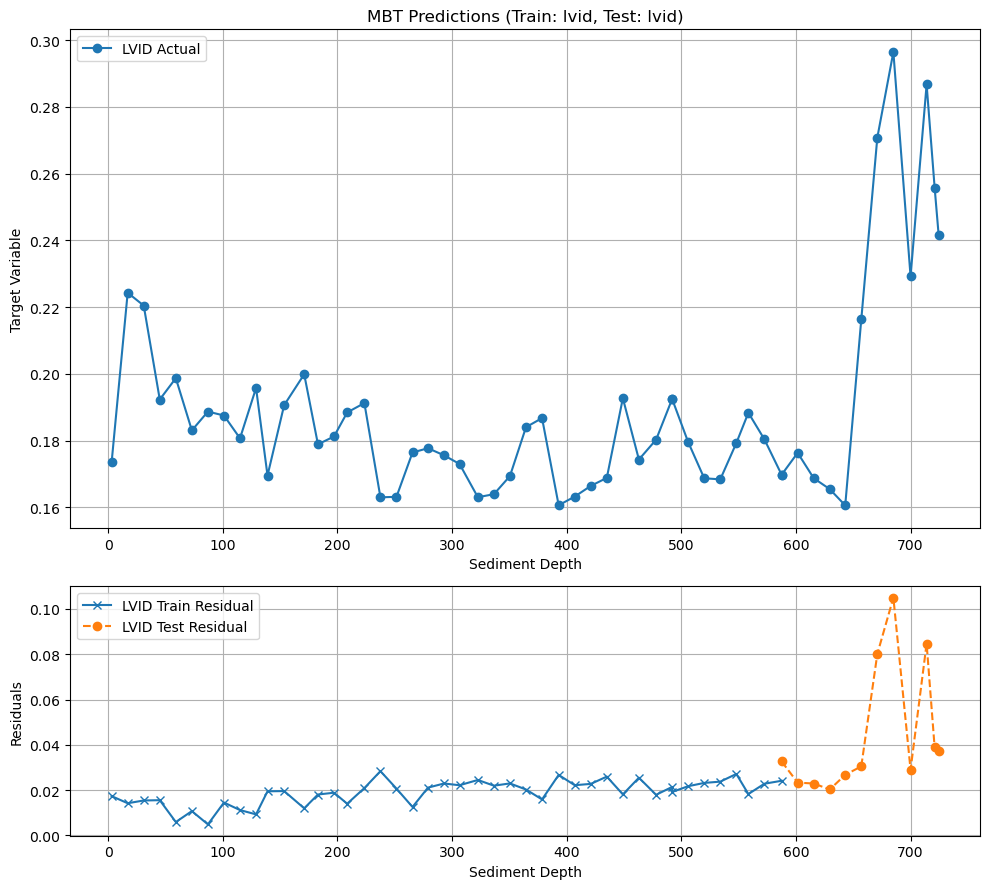

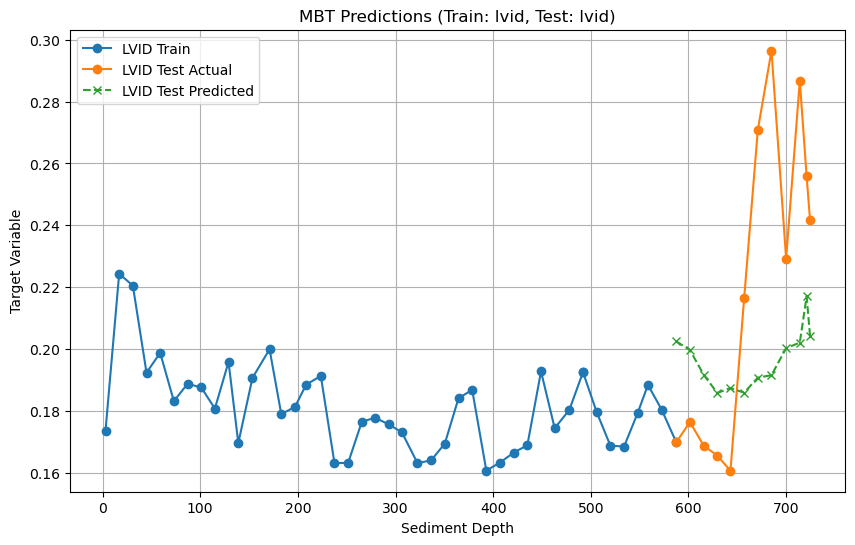

Running experiment for Target: MBT, Train: lvid, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


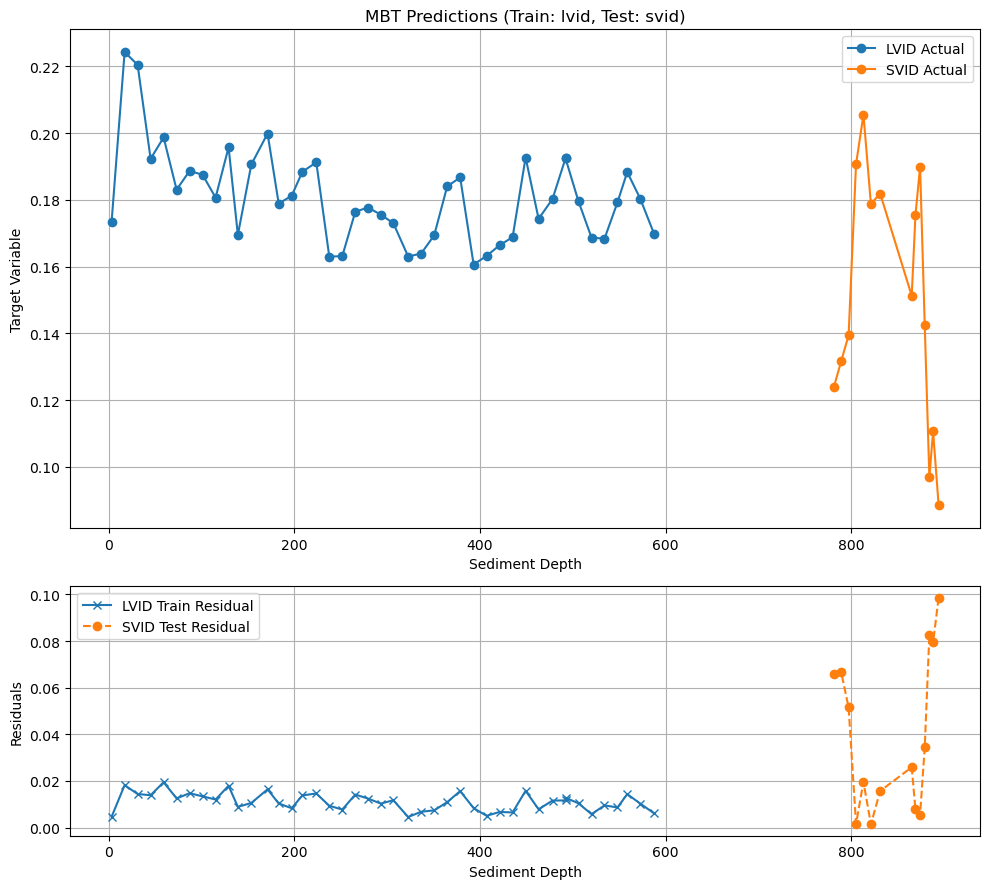

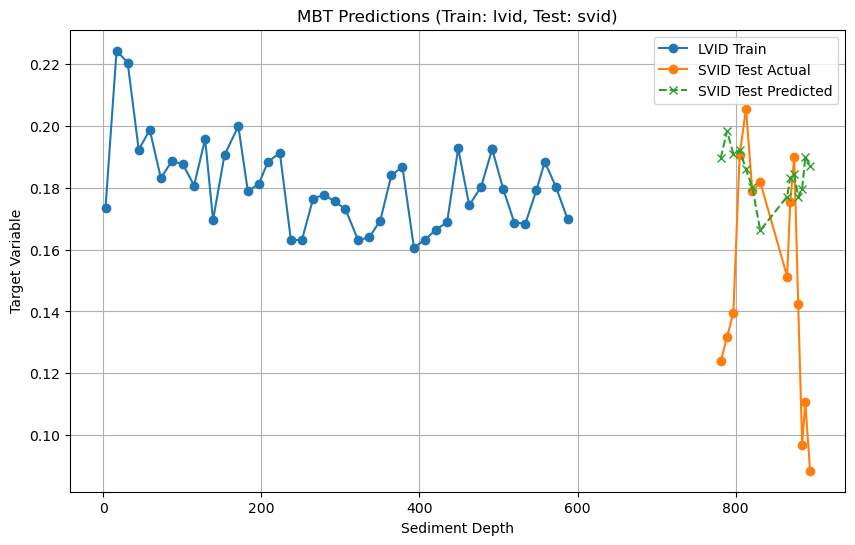

Running experiment for Target: MBT, Train: lvid, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


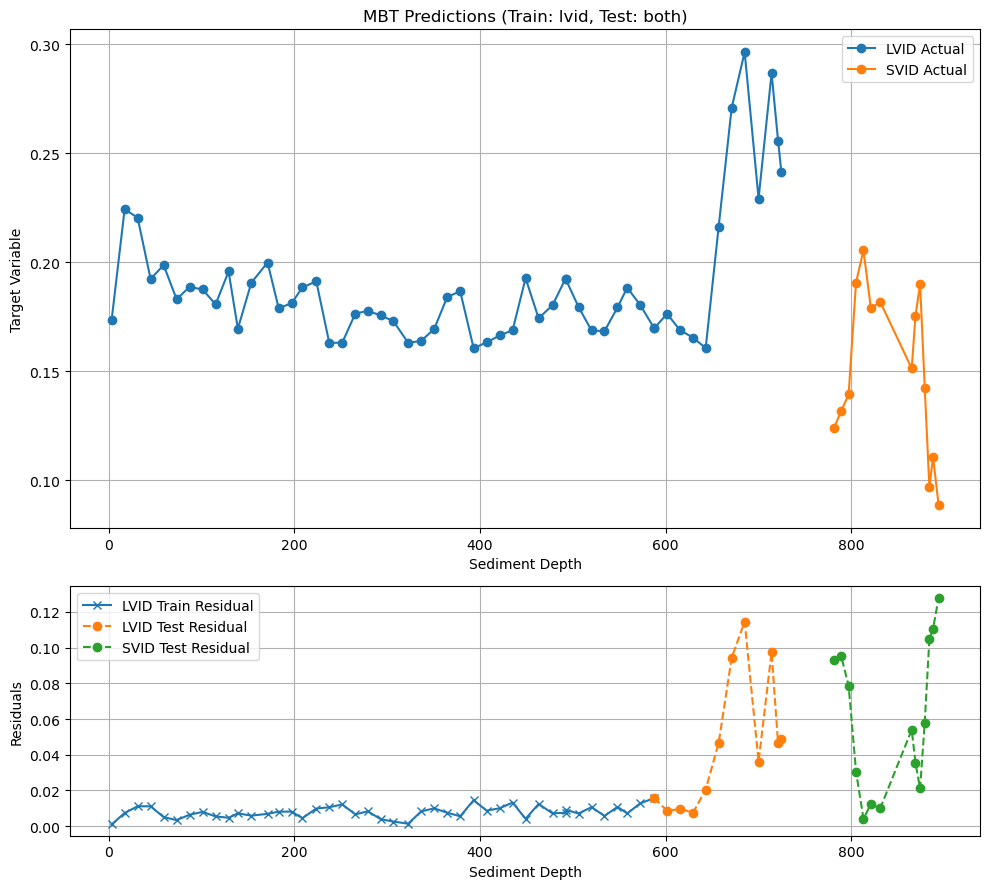

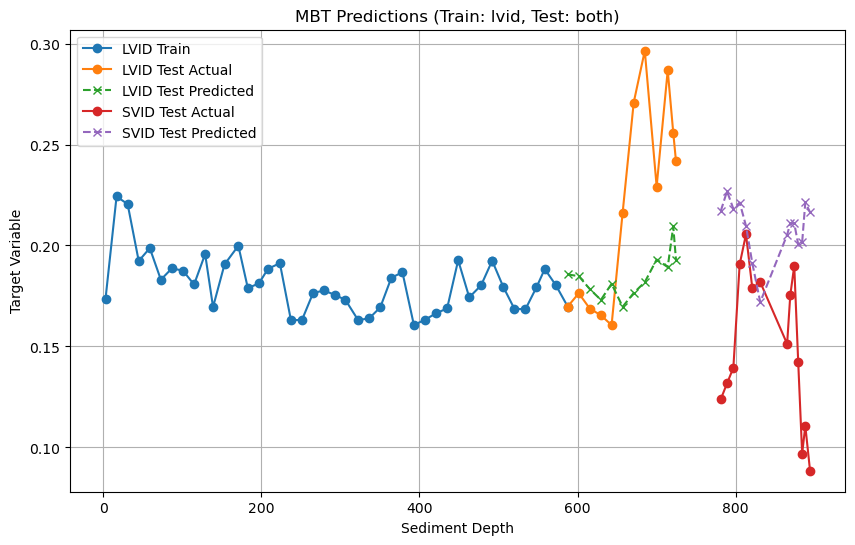

Running experiment for Target: MBT, Train: svid, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


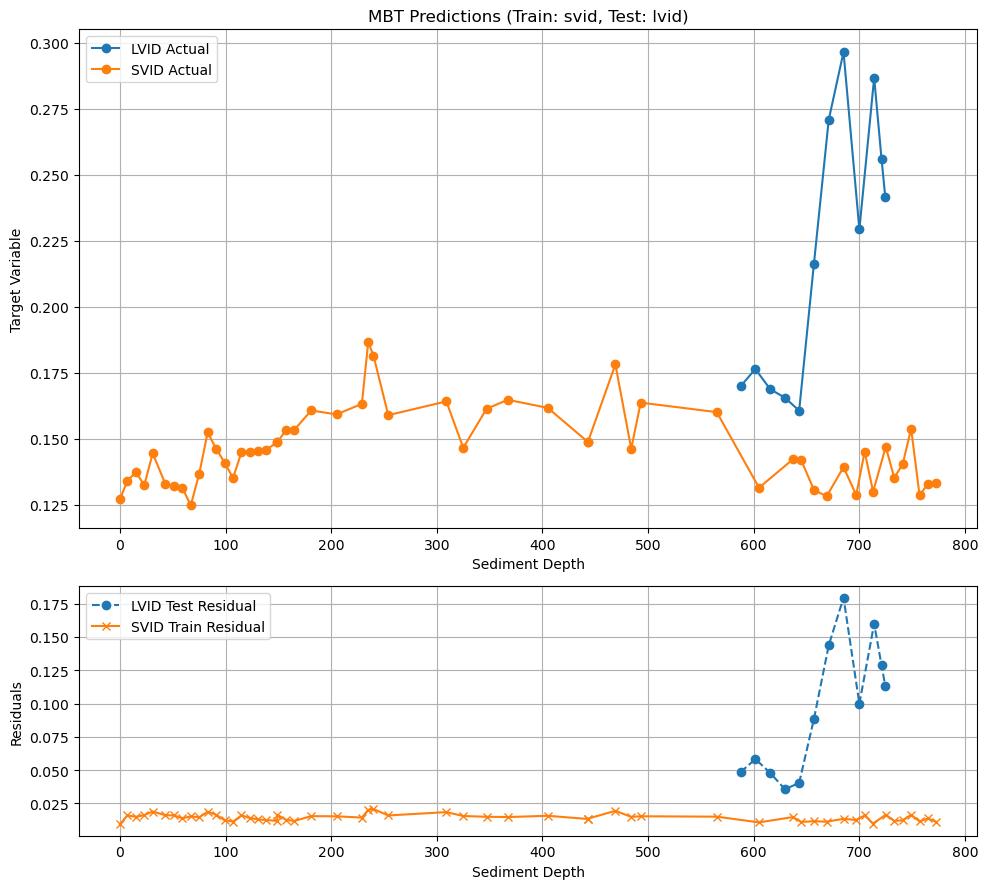

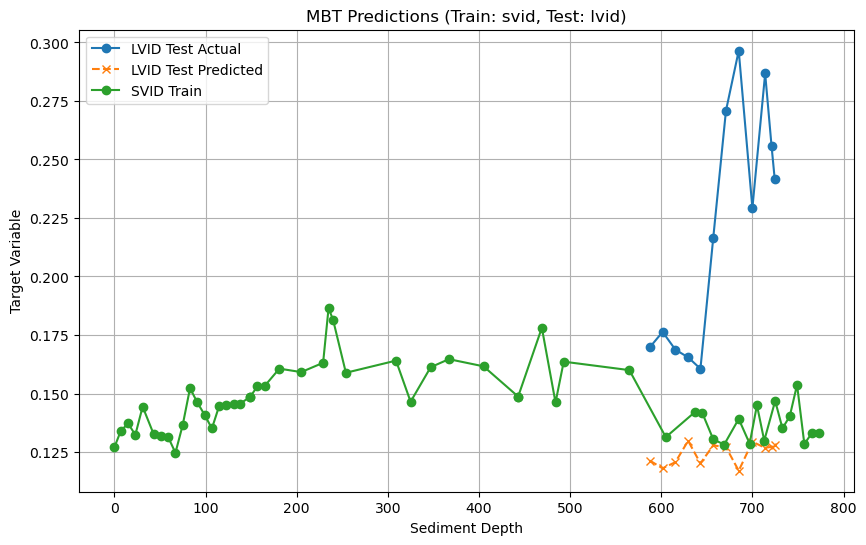

Running experiment for Target: MBT, Train: svid, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


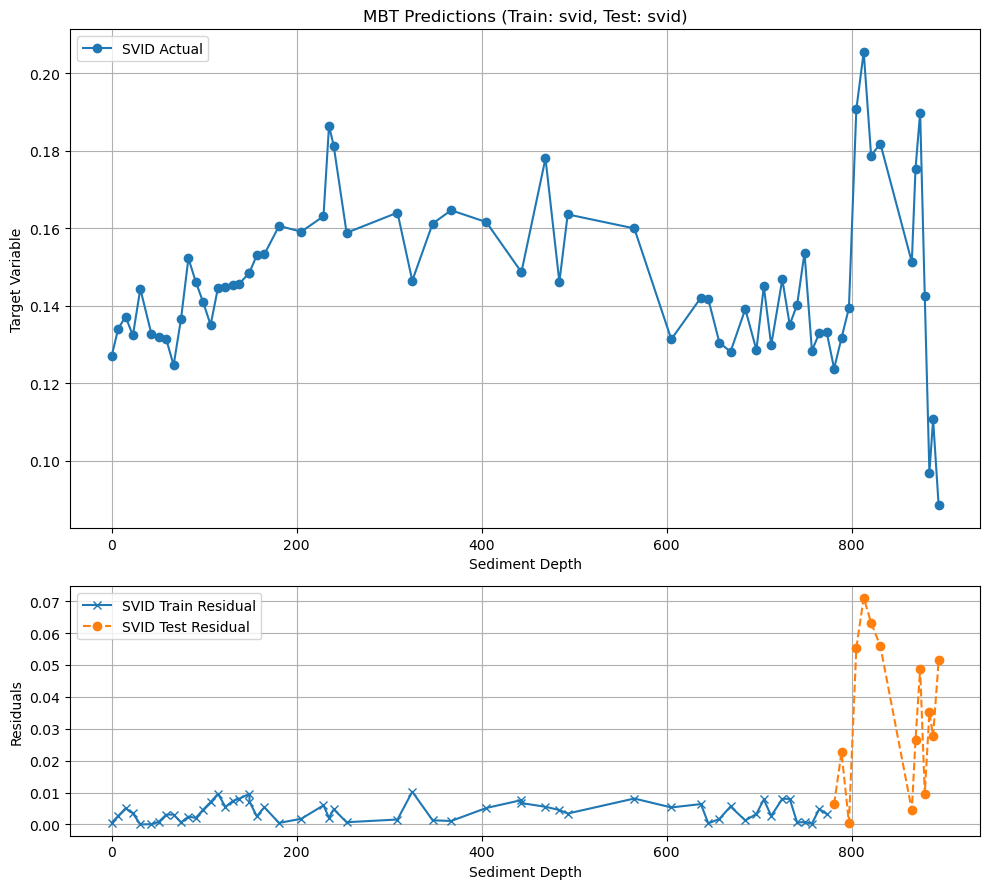

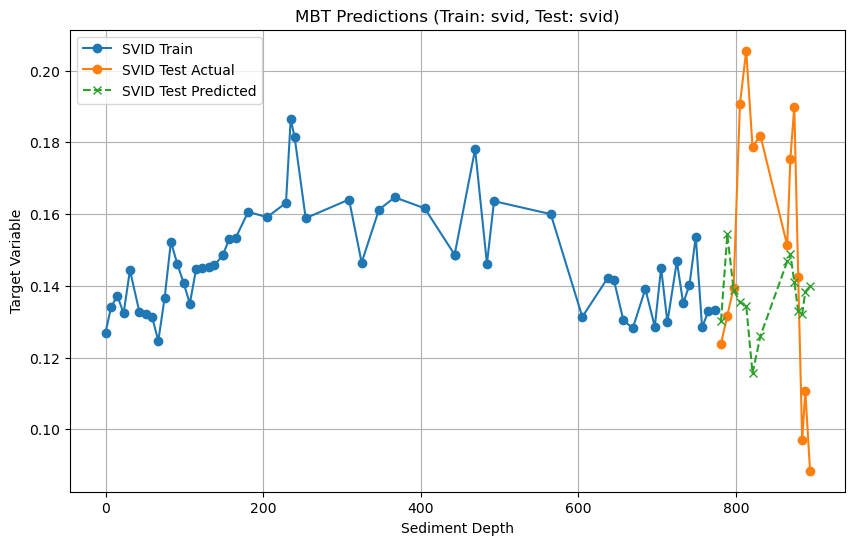

Running experiment for Target: MBT, Train: svid, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


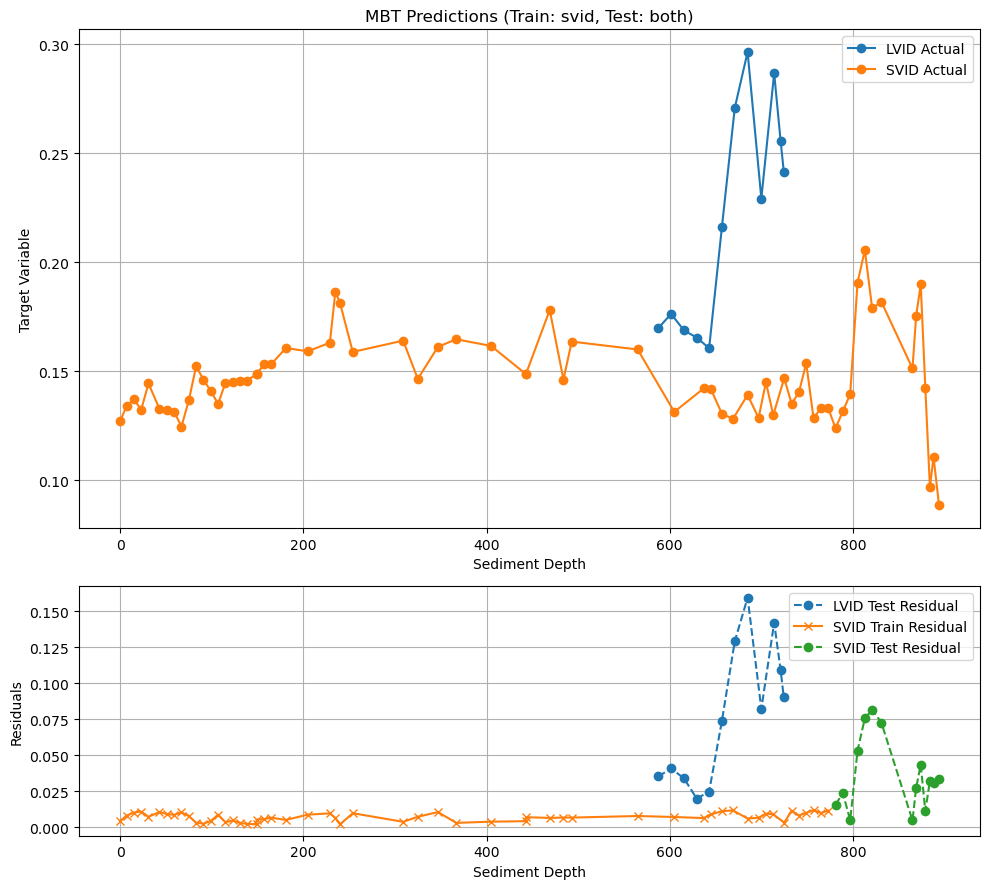

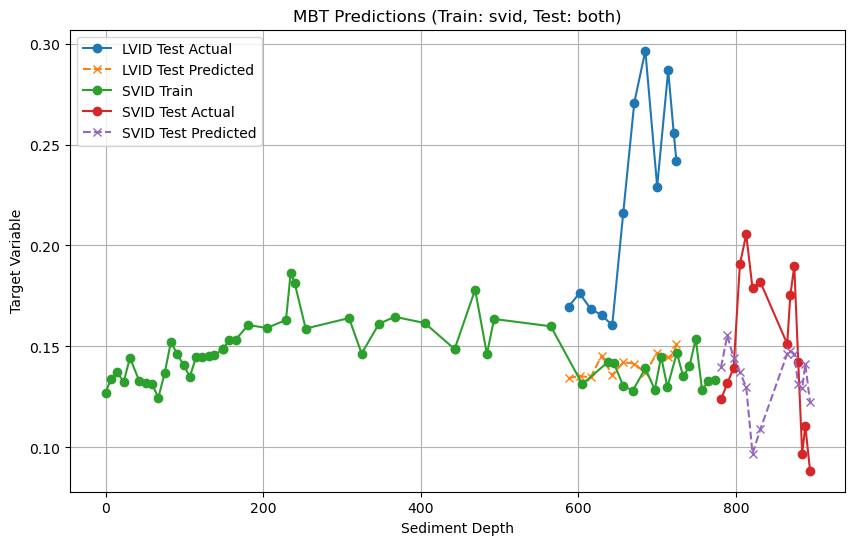

Running experiment for Target: MBT, Train: both, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


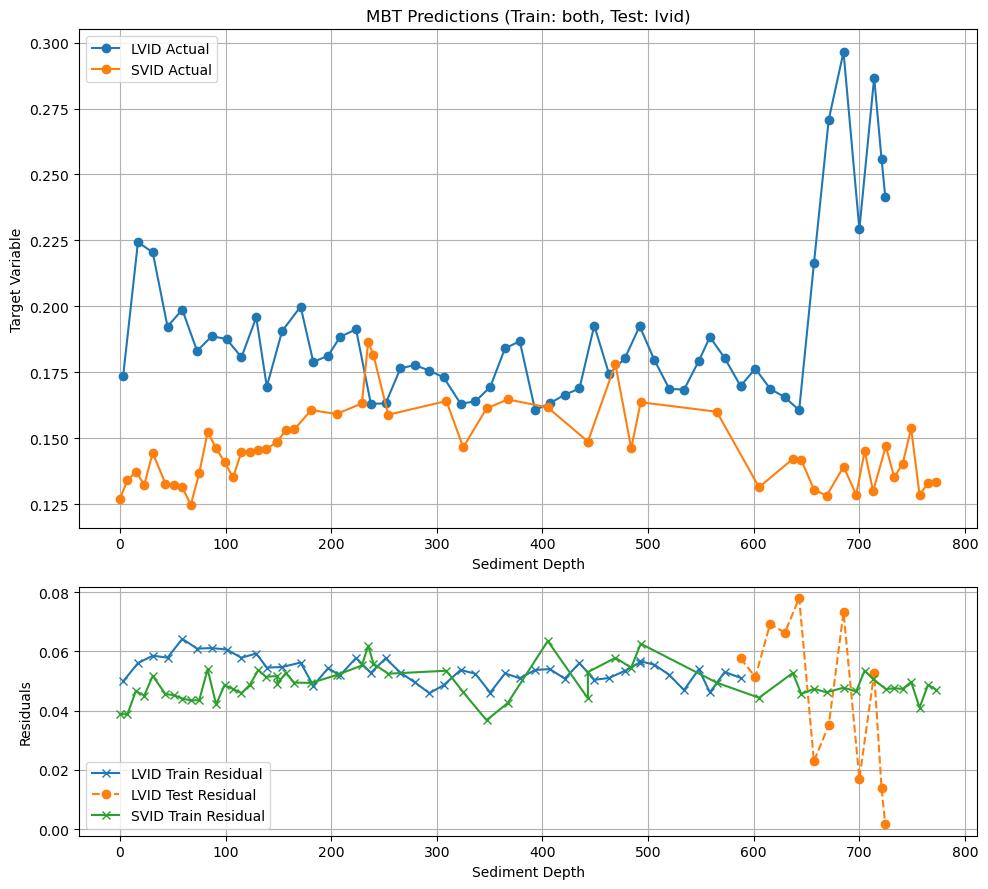

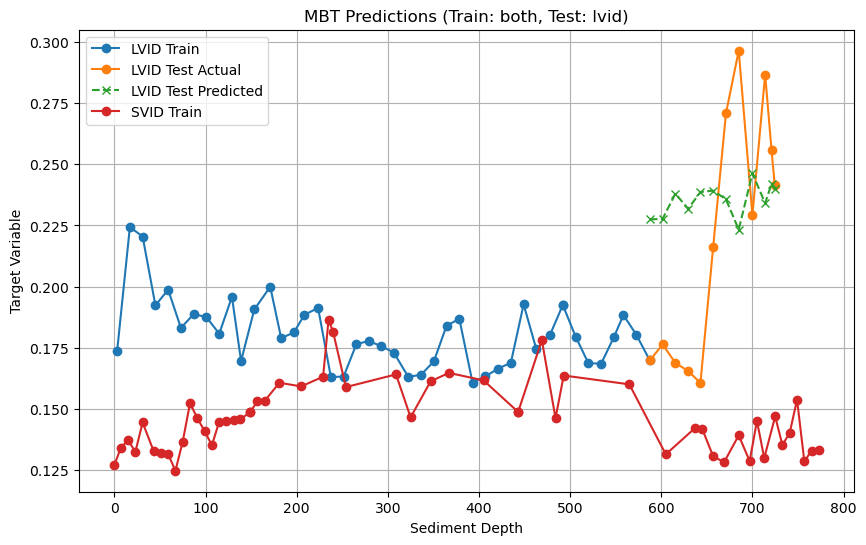

Running experiment for Target: MBT, Train: both, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


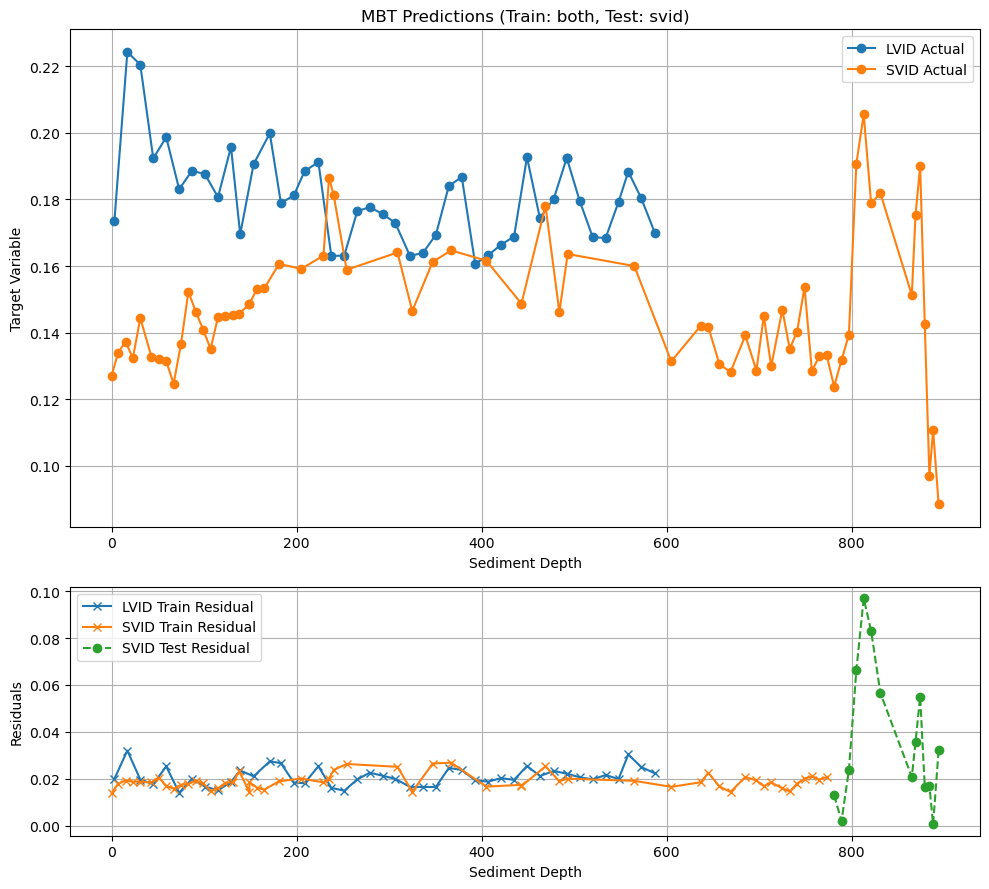

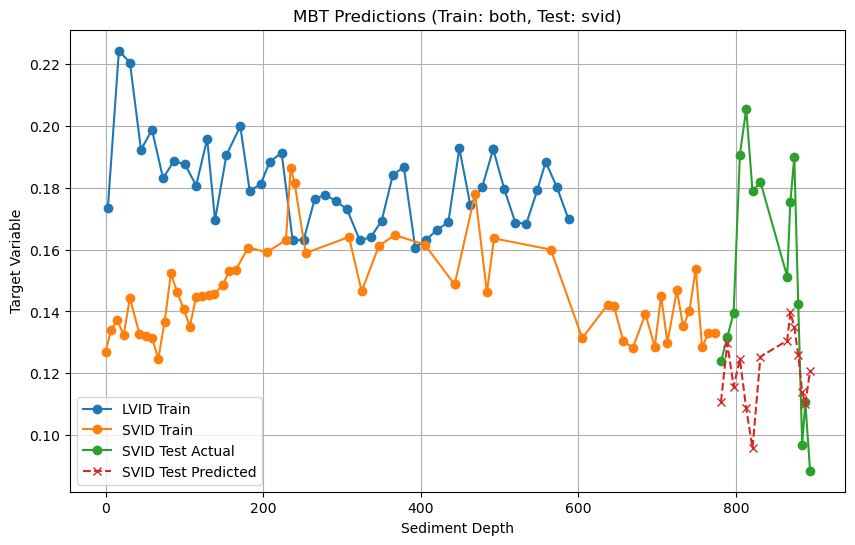

Running experiment for Target: MBT, Train: both, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


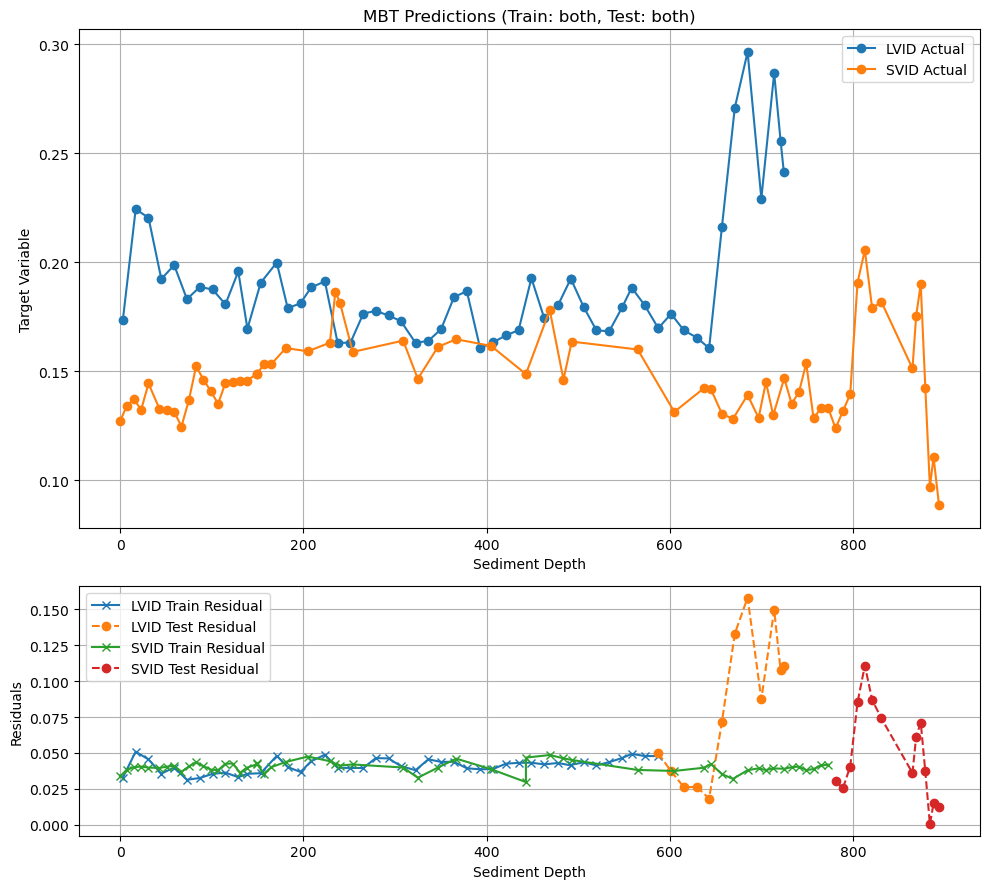

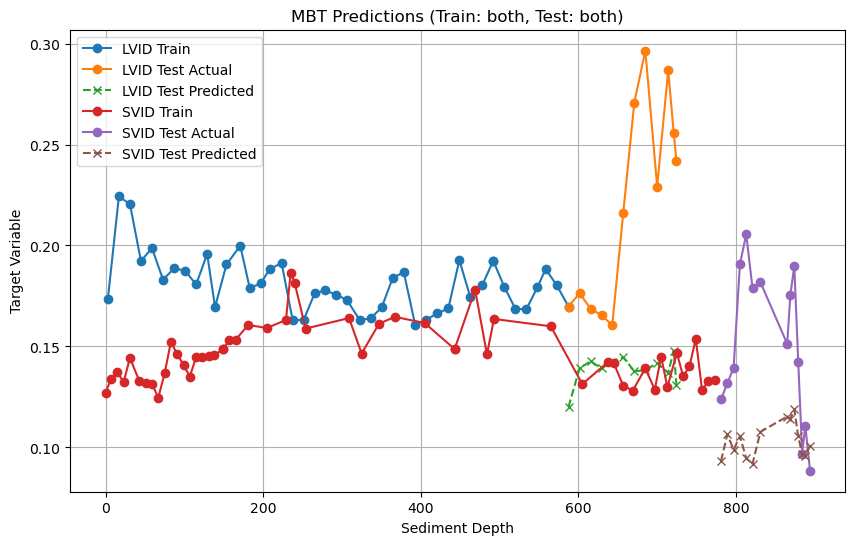

Running experiment for Target: %TOC, Train: lvid, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


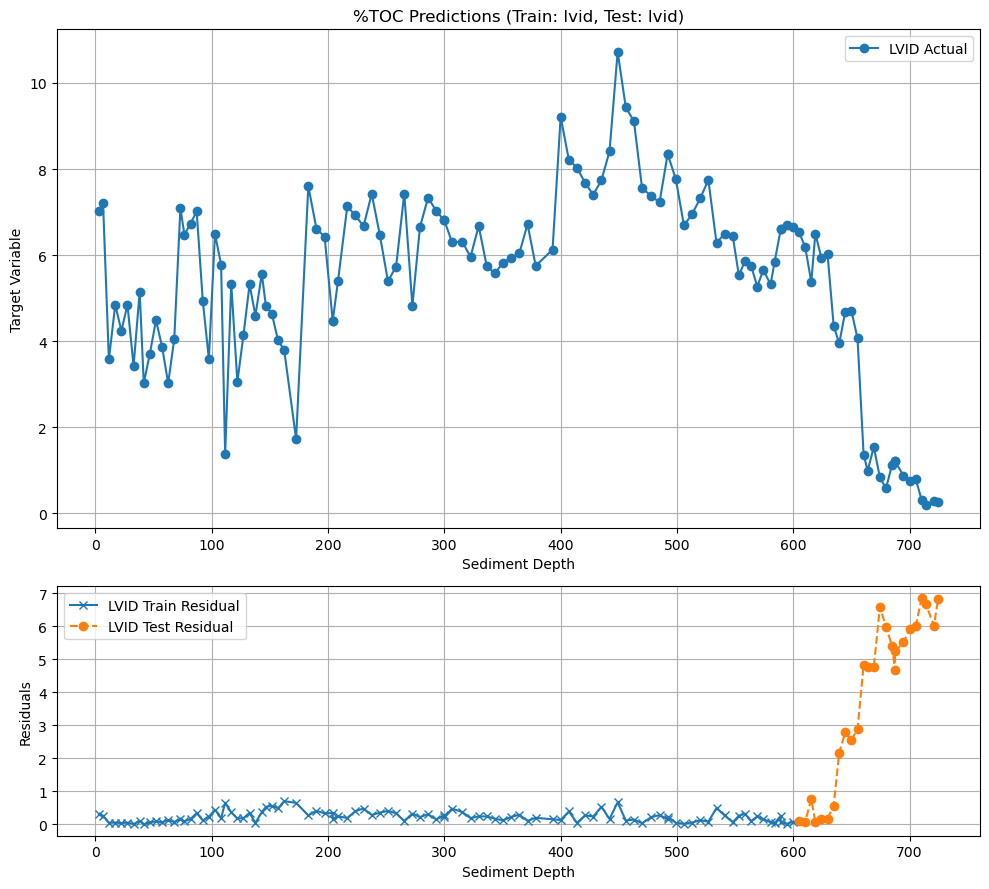

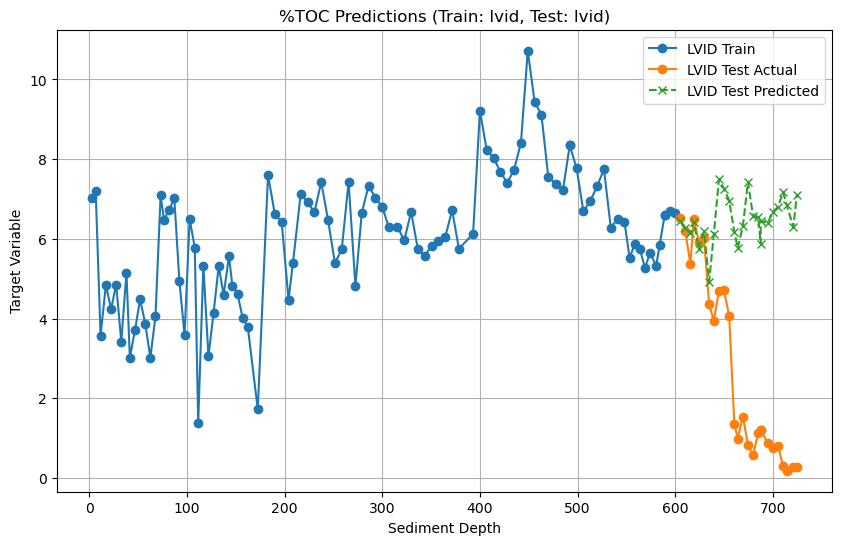

Running experiment for Target: %TOC, Train: lvid, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


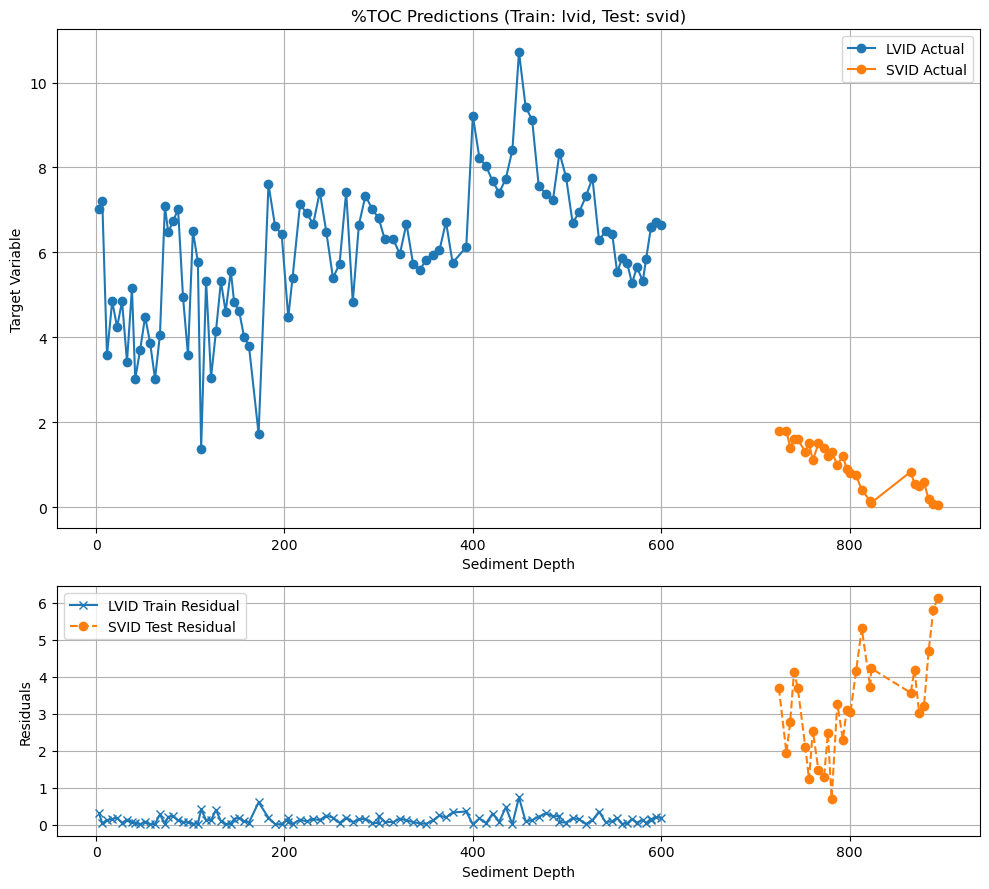

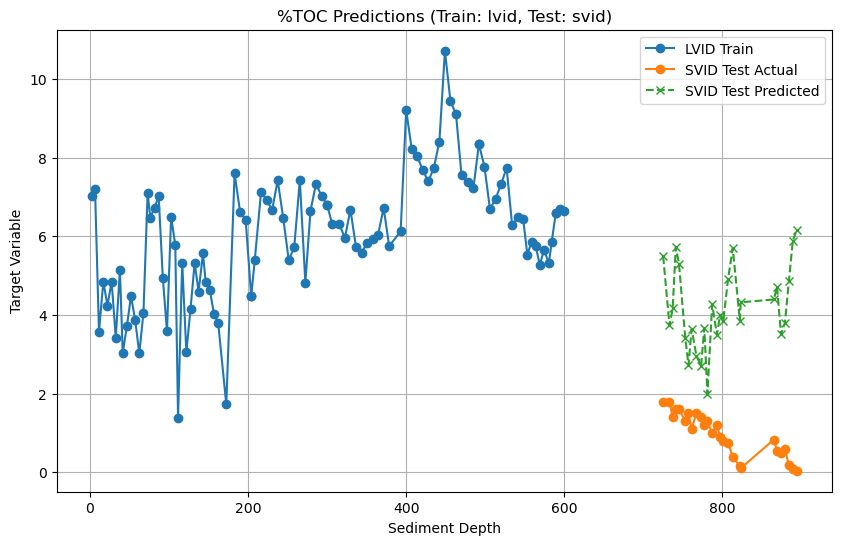

Running experiment for Target: %TOC, Train: lvid, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


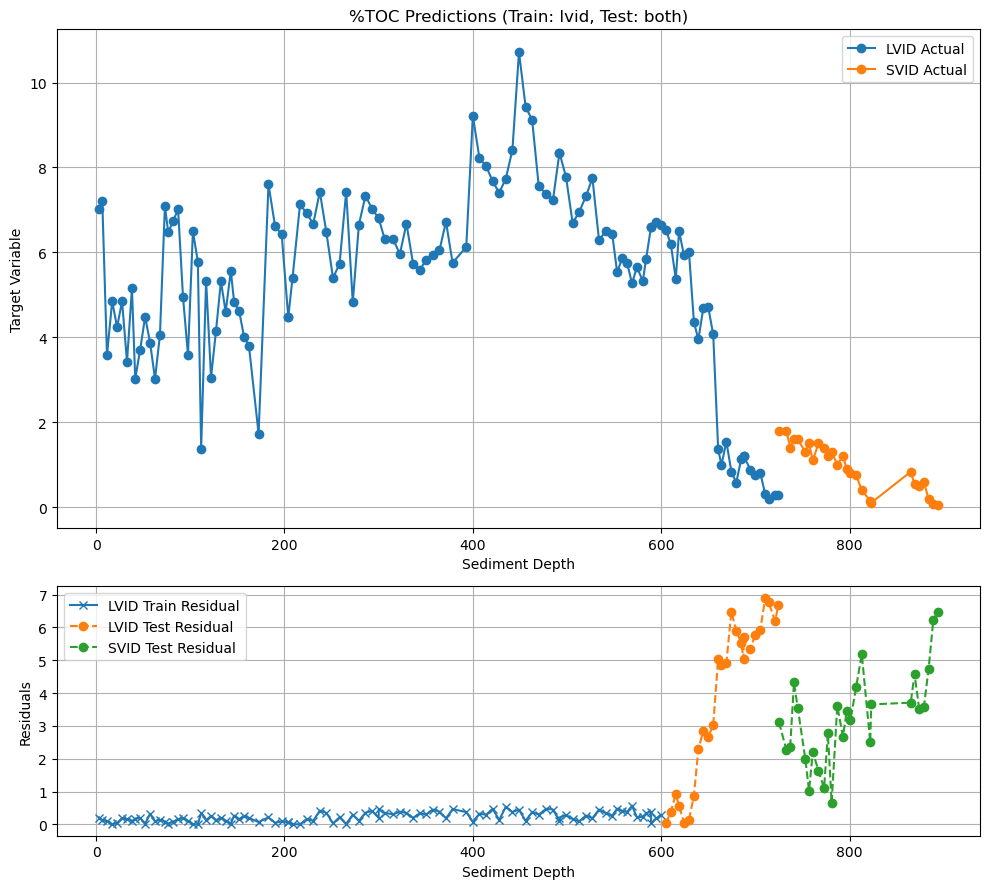

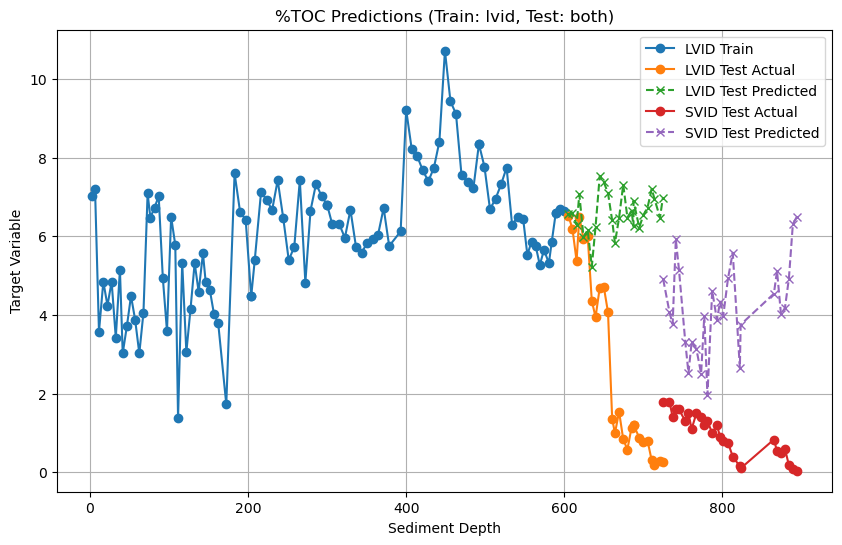

Running experiment for Target: %TOC, Train: svid, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


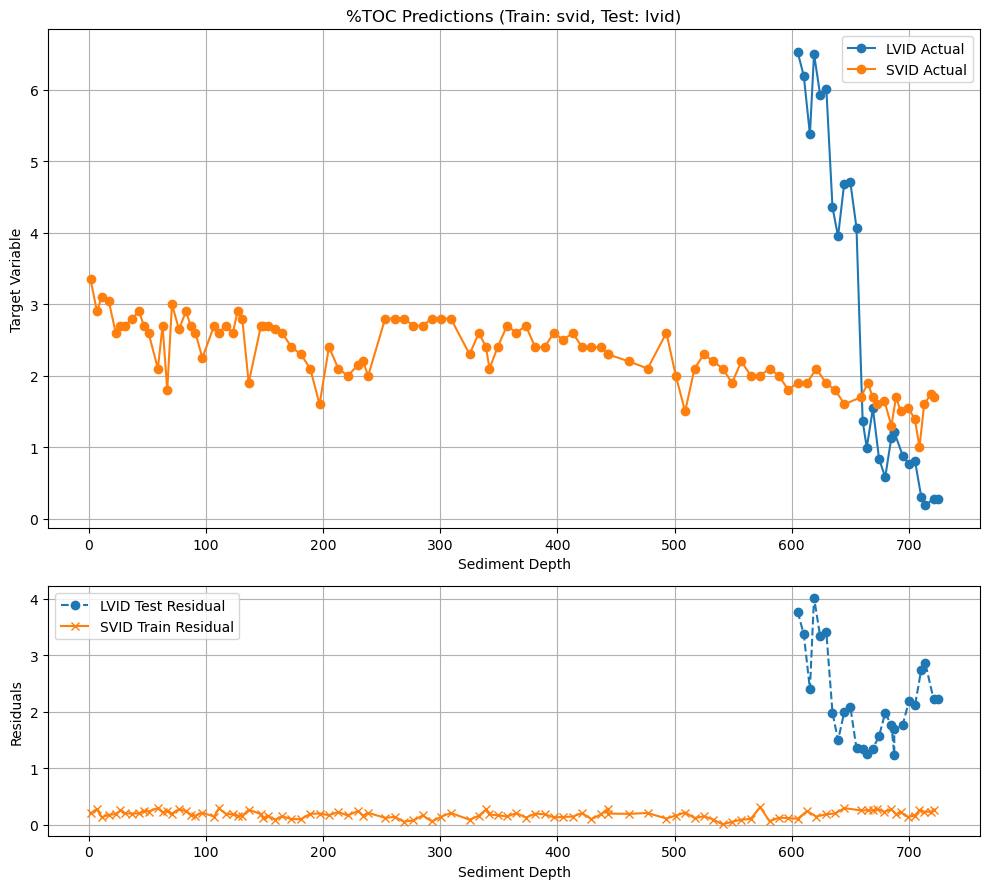

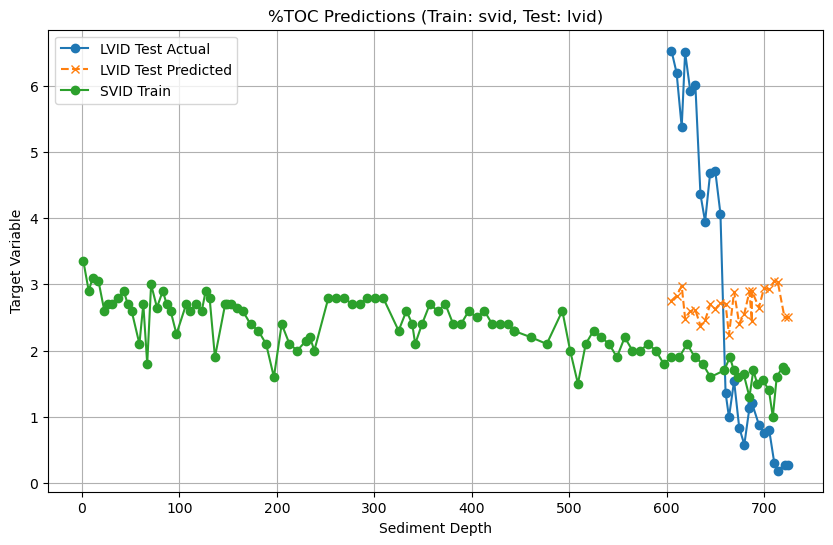

Running experiment for Target: %TOC, Train: svid, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


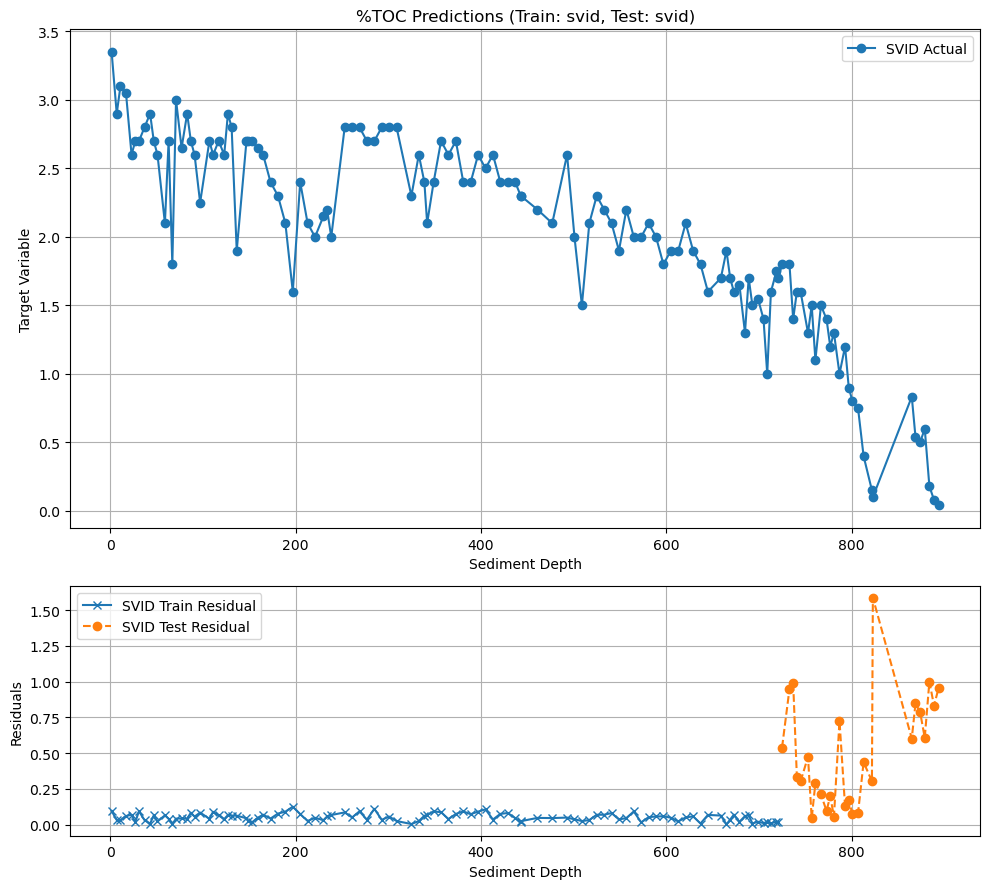

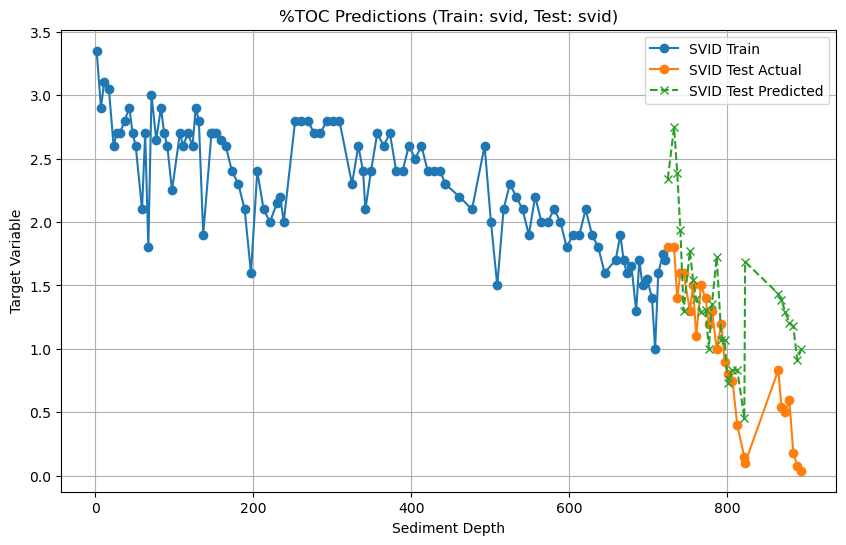

Running experiment for Target: %TOC, Train: svid, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


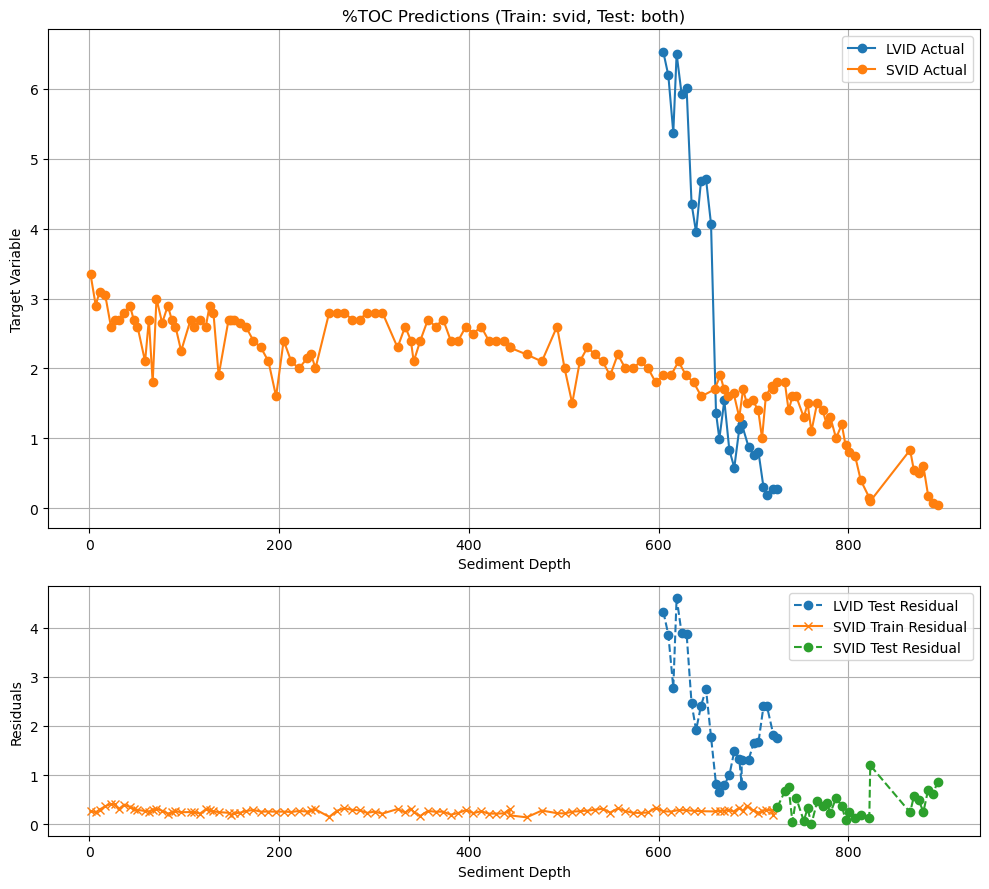

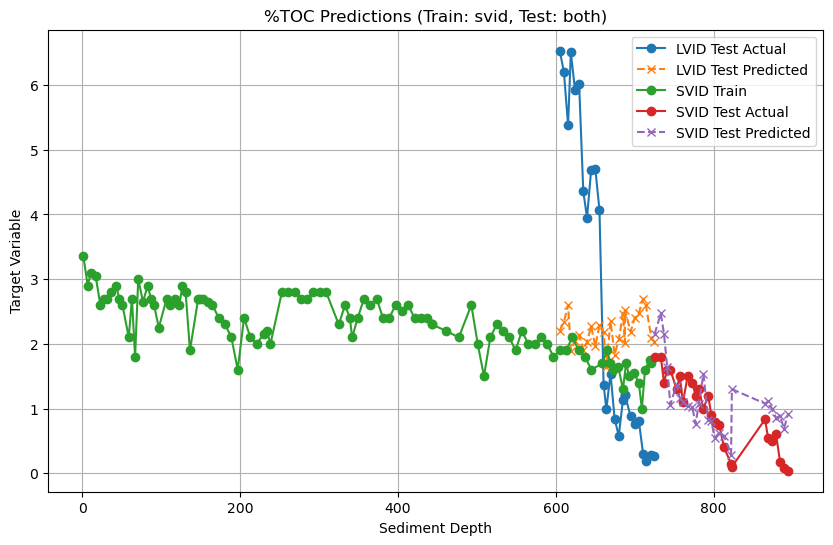

Running experiment for Target: %TOC, Train: both, Test: lvid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


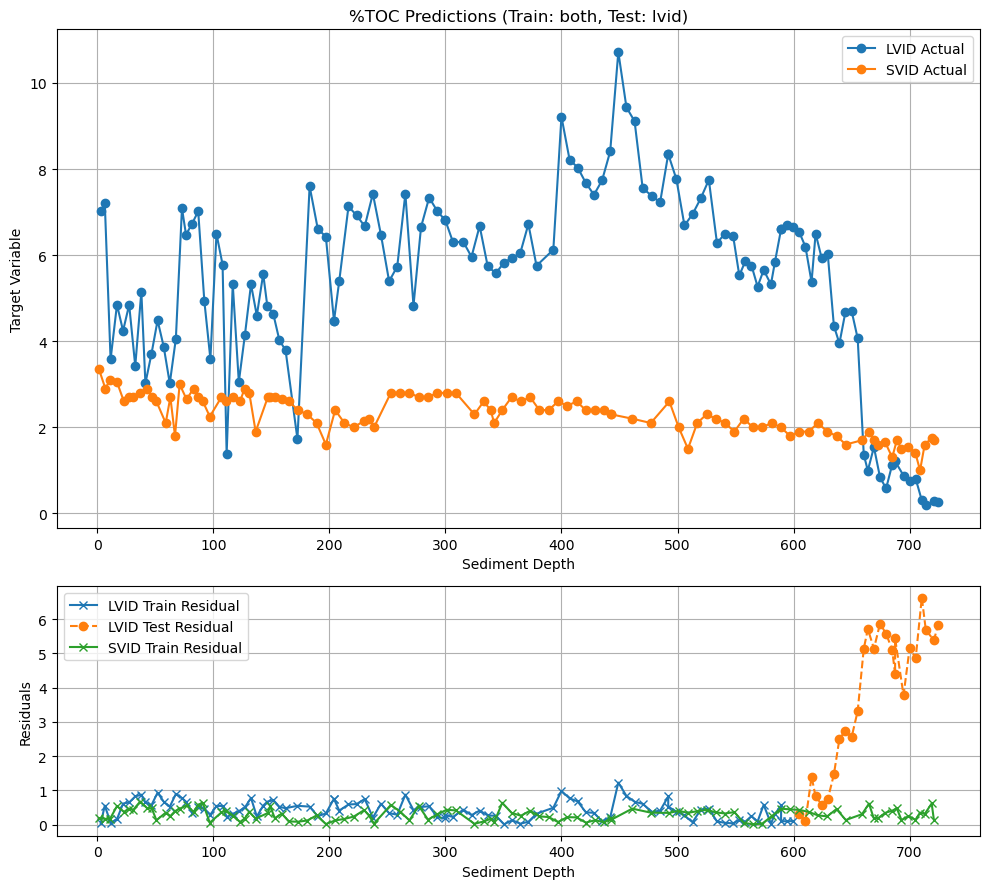

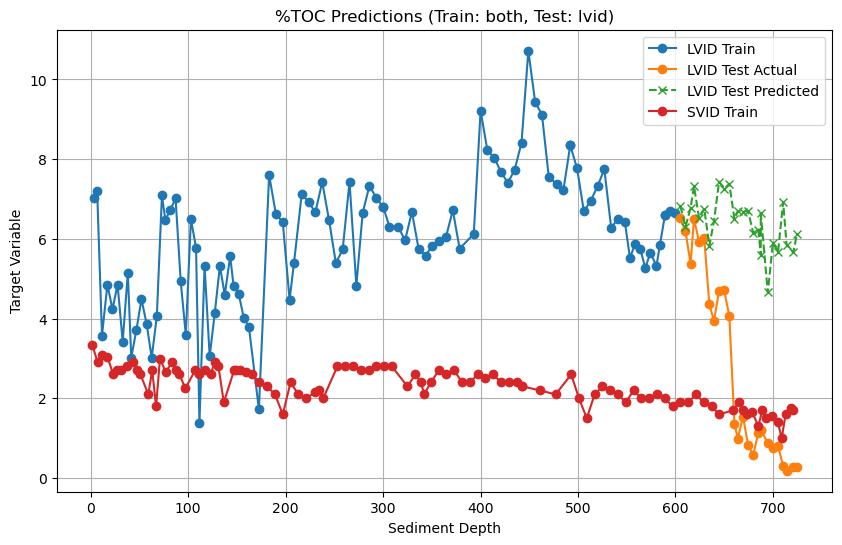

Running experiment for Target: %TOC, Train: both, Test: svid


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


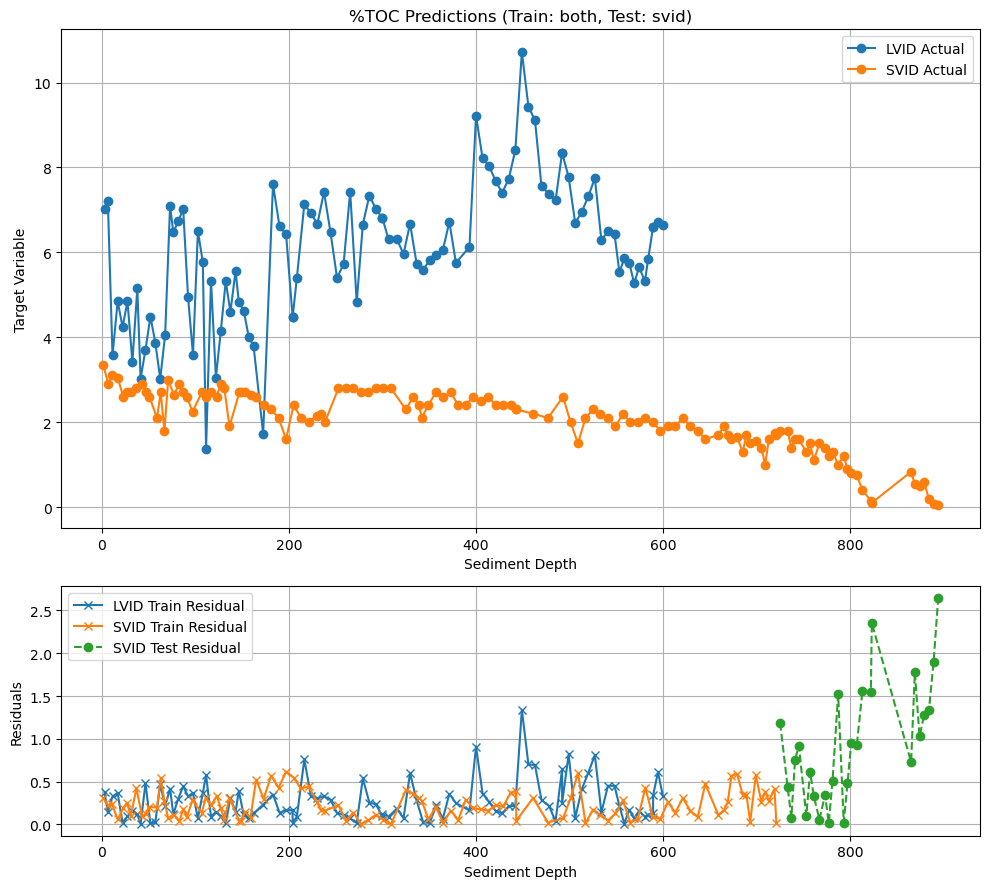

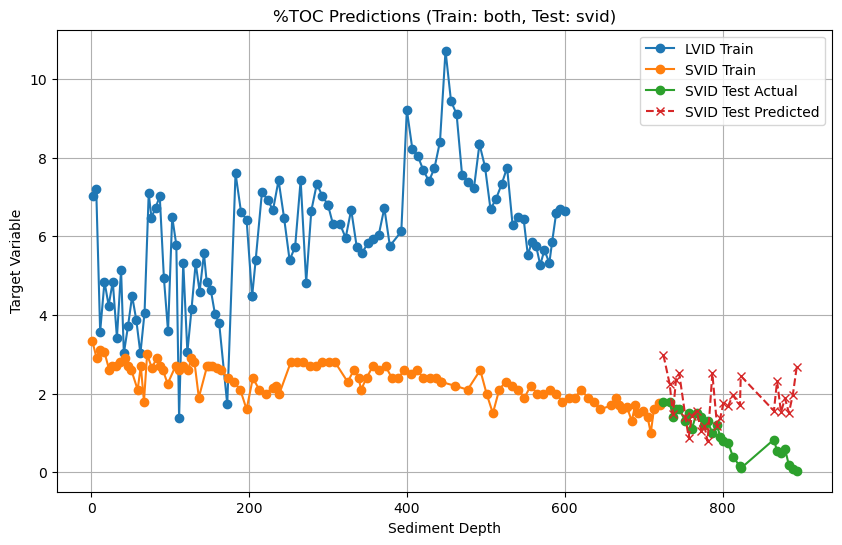

Running experiment for Target: %TOC, Train: both, Test: both


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


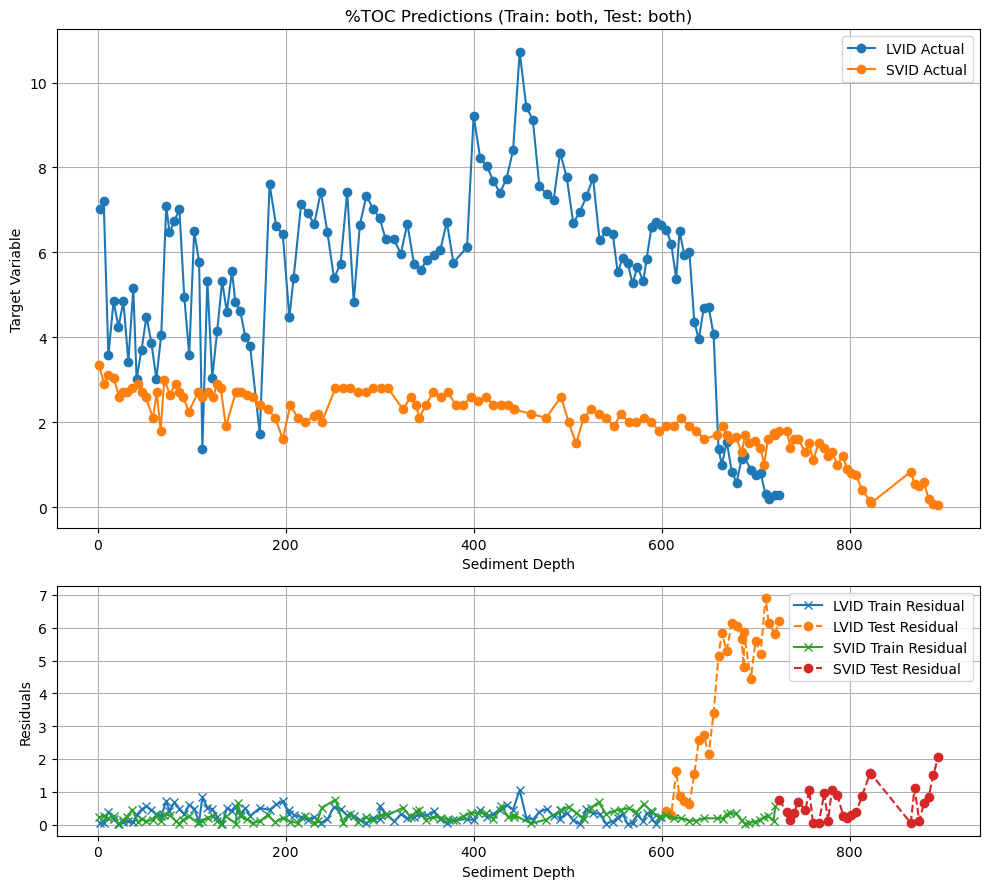

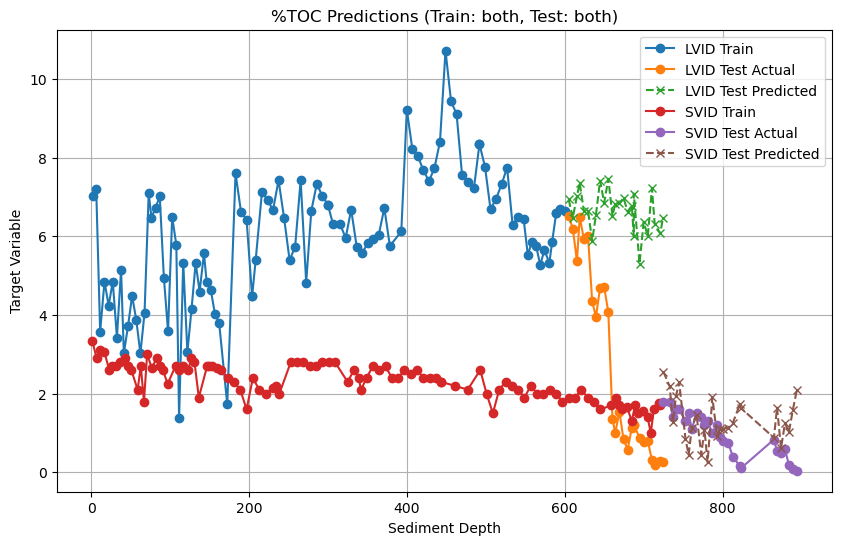

In [8]:
results = []

# Define the combinations
combinations = [
    ("lvid", "lvid"),
    ("lvid", "svid"),
    ("lvid", "both"),
    ("svid", "lvid"),
    ("svid", "svid"),
    ("svid", "both"),
    ("both", "lvid"),
    ("both", "svid"),
    ("both", "both")
]
targets = ['MBT', '%TOC']
# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

for target in targets:
    for train_set, test_set in combinations:
        cnn_model = RegressionCNN(embedding_dim=192)
        print(f"Running experiment for Target: {target}, Train: {train_set}, Test: {test_set}")
        
        # Load data
        train_loader, _, train_scaler = load_data(target, lake=train_set, set="full", scaled=False, random = False)
        _, test_loader, _ = load_data(target, lake=test_set, set="full", scaled=False, random = False)
        
        train_depths, train_actuals, train_sources, train_predictions, test_depths, test_actuals, test_predictions, test_sources = run_experiment(train_loader, test_loader, cnn_model, custom_model, train_scaler, num_epochs=100, lr=0.001)
        

        timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
        save_dir = 'data_exp/sequential/5cm/plots/new'
        os.makedirs(save_dir, exist_ok=True)
        filename = f'{target}_{train_set}train{test_set}_test_{timestamp}.png'
        plot_title = f"{target} Predictions (Train: {train_set}, Test: {test_set})"
        save_path = os.path.join(save_dir, filename)
        plot_results(train_depths, train_actuals, train_predictions, train_sources,  test_depths, test_actuals, test_predictions, test_sources, plot_title, save_path)
        save_dir = 'data_exp/sequential/5cm/plots/old'
        os.makedirs(save_dir, exist_ok=True)
        filename = f'OLD{target}_{train_set}train{test_set}_test_{timestamp}.png'
        save_path = os.path.join(save_dir, filename)
        old_plot_results(train_depths, train_actuals, train_predictions, train_sources, test_depths, test_actuals, test_predictions, test_sources, plot_title, save_path)

        # Calculate performance metrics
        rmse_value = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        r2_value = r2_score(test_actuals, test_predictions)

        # Add the results to the results dataframe
        results.append({
            "Train Set": train_set,
            "Test Set": test_set,
            "Target": target,
            "RMSE": rmse_value
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = 'data_exp/sequential/5cm/results'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'experiment_results_{timestamp}.csv'
# Save the results to a CSV file
results_df.to_csv(os.path.join(save_dir, filename), index=False)

